In [1]:
# --------------------------------- Part 1: Imports ---------------------------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, auc, accuracy_score)
from scipy.stats import ttest_rel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Conv1D, Flatten, concatenate, Dropout,
                                     Multiply, Reshape, BatchNormalization, GlobalAveragePooling1D,
                                     Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df1 = pd.read_csv("UNSW_filtered_data.csv")
df1.shape

(2784, 44)

In [3]:
df2= pd.read_csv("UNSW_augmented_filtered_data.csv")
df2.shape

(257673, 44)

In [4]:
df=pd.concat([df1,df2],axis=0)
df.shape

(260457, 44)

In [5]:
## From the IMOA feature selecting
selected_features = ['dur','proto','service','state','sbytes','dbytes','dload','sloss','sinpkt','sjit','swin','stcpb','dtcpb',
'dwin','synack','ackdat','dmean','trans_depth','ct_state_ttl','ct_dst_src_ltm','ct_ftp_cmd','ct_src_ltm']
# Drop columns not in the list
df_filtered = df[selected_features]

In [6]:
X = df_filtered.iloc[:, :].values  # Features (excluding the label column)
y = df.iloc[:, -1].values   # Labels

In [7]:
# --------------------------------- Part 3: Define Models ---------------------------------
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(inputs, output)

def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(inputs, output)

def create_fnn_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(inputs, output)

def attention_mechanism(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax', name='attention_weights')(inputs)
    attention_output = Multiply(name='attention_output')([inputs, attention_weights])
    return attention_output, attention_weights


In [8]:
pip install memory-profiler

Note: you may need to restart the kernel to use updated packages.


In [9]:
from memory_profiler import memory_usage

In [10]:
def train_ensemble():
    return ensemble_model.fit(
        [X_train_cnn, X_train_cnn, X_train], y_train,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        verbose=0,
        validation_data=([X_test_cnn, X_test_cnn, X_test], y_test)
    )

In [12]:
# --------------------------------- Part 4: 5-Fold Cross-Validation Setup ---------------------------------
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ensemble_accs, cnn_accs, lstm_accs, fnn_accs = [], [], [], []
ensemble_times, cnn_times, lstm_times, fnn_times = [], [], [], []
ensemble_memory_usages, cnn_memory_usages, lstm_memory_usages, fnn_memory_usages = [], [], [], []
all_y_test = []
all_ensemble_pred = []
all_cnn_pred =[]
all_lstm_pred=[]
all_fnn_pred=[]
all_ensemble_prob = []
all_cm = []
fold = 1
for train_idx, test_idx in kfold.split(X, y):
    print(f"\n=== Fold {fold} ===")
    fold += 1

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # CNN
    print("Processing CNN Model")
    cnn_model = create_cnn_model((X_train_cnn.shape[1], 1))
    cnn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    start = time.time()
    cnn_mem_usage, cnn_history = memory_usage(
    (cnn_model.fit, (X_train_cnn, y_train), {'epochs': 50, 'batch_size': 64, 'validation_split': 0.1, 'verbose': 0}),
    interval=0.1,
    retval=True )
    #cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=0)
    end = time.time()
    cnn_times.append(end - start)
    cnn_peak_memory = max(cnn_mem_usage)
    cnn_memory_usages.append(cnn_peak_memory)
    cnn_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)
    cnn_accs.append(accuracy_score(y_test, cnn_pred))
    all_cnn_pred.append(cnn_pred)

    # LSTM
    print("Processing LSTM Model")
    lstm_model = create_lstm_model((X_train_cnn.shape[1], 1))
    lstm_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    start = time.time()
    lstm_mem_usage, lstm_history = memory_usage(
    (lstm_model.fit, (X_train_cnn, y_train), {'epochs': 50, 'batch_size': 64, 'validation_split': 0.1, 'verbose': 0}),
     interval=0.1,retval=True)
    #lstm_history= lstm_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=0)
    end = time.time()
    lstm_times.append(end - start)
    lstm_peak_memory = max(lstm_mem_usage)
    lstm_memory_usages.append(lstm_peak_memory)
    lstm_pred = (lstm_model.predict(X_test_cnn) > 0.5).astype(int)
    lstm_accs.append(accuracy_score(y_test, lstm_pred))
    all_lstm_pred.append(lstm_pred)

    # FNN
    print("Processing FNN Model")
    fnn_model = create_fnn_model(X_train.shape[1])
    fnn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    start = time.time()
    fnn_mem_usage, fnn_history = memory_usage(
    (fnn_model.fit, (X_train, y_train), {'epochs': 50, 'batch_size': 64, 'validation_split': 0.1, 'verbose': 0}),
    interval=0.1,
    retval=True)
    #fnn_history=fnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=0)
    end = time.time()
    fnn_times.append(end - start)
    fnn_peak_memory = max(fnn_mem_usage)
    fnn_memory_usages.append(fnn_peak_memory)
    fnn_pred = (fnn_model.predict(X_test) > 0.5).astype(int)
    fnn_accs.append(accuracy_score(y_test, fnn_pred))
    all_fnn_pred.append(fnn_pred)

    # Ensemble
    print("Processing Ensemble Model")
    cnn_out = Lambda(lambda x: x)(cnn_model.output)
    lstm_out = Lambda(lambda x: x)(lstm_model.output)
    fnn_out = Lambda(lambda x: x)(fnn_model.output)
    combined = concatenate([cnn_out, lstm_out, fnn_out])
    combined_dense = Dense(22, activation='relu')(combined)
    attention_output, attention_weights = attention_mechanism(combined_dense)
    final_output = Dense(1, activation='sigmoid')(attention_output)
    ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=final_output)
    ensemble_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    start = time.time()
    ensemble_mem_usage, ensemble_history = memory_usage(
    train_ensemble,interval=0.1,retval=True)
    ensemble_peak_memory = max(ensemble_mem_usage)
    ensemble_memory_usages.append(ensemble_peak_memory)
    end = time.time()
    ensemble_times.append(end - start)
    ensemble_pred = (ensemble_model.predict([X_test_cnn, X_test_cnn, X_test]) > 0.5).astype(int)
    ensemble_accs.append(accuracy_score(y_test, ensemble_pred))
    all_y_test.append(y_test)
    all_ensemble_pred.append(ensemble_pred)
    all_ensemble_prob.append(ensemble_model.predict([X_test_cnn, X_test_cnn, X_test]))  # Probabilities for ROC/PR
    cm = confusion_matrix(y_test, ensemble_pred)
    all_cm.append(cm)



=== Fold 1 ===
Processing CNN Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Processing LSTM Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step
Processing FNN Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Processing Ensemble Model

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step

=== Fold 2 ===
Processing CNN Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Processing LSTM Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step
Processing FNN Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Processing Ensemble Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step

=== Fold 3 ===
Processing CNN Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Processing LSTM Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step
Processing FNN Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Processing Ensemble Model
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step

=== Fold 4 ===
Pro

In [47]:

# --------------------------------- Part 5: Report Results ---------------------------------
def report_scores(name, scores, times, memories):
    print(f"{name}: Accuracy = {np.mean(scores):.4f} ± {np.std(scores):.4f}, "
          f"Time = {np.mean(times):.2f}s ± {np.std(times):.2f}s, "
          f"Memory = {np.mean(memories):.2f} MiB ± {np.std(memories):.2f} MiB")

print("\n=== 5-Fold Cross-validation Results ===")
report_scores("CNN", cnn_accs, cnn_times, cnn_memory_usages)
report_scores("LSTM", lstm_accs, lstm_times, lstm_memory_usages)
report_scores("FNN", fnn_accs, fnn_times, fnn_memory_usages)
report_scores("Ensemble", ensemble_accs, ensemble_times, ensemble_memory_usages)


=== 5-Fold Cross-validation Results ===
CNN: Accuracy = 0.9590 ± 0.0815, Time = 904.67s ± 26.81s, Memory = 839.07 MiB ± 247.97 MiB
LSTM: Accuracy = 0.9700 ± 0.0000, Time = 4991.16s ± 246.31s, Memory = 879.13 MiB ± 215.07 MiB
FNN: Accuracy = 0.9800 ± 0.0000, Time = 480.41s ± 20.58s, Memory = 828.51 MiB ± 281.62 MiB
Ensemble: Accuracy = 1.0000 ± 0.0000, Time = 5597.69s ± 1055.79s, Memory = 1053.21 MiB ± 217.09 MiB


In [25]:

# --------------------------------- Part 6: Statistical Significance Testing ---------------------------------
print("\n=== Paired t-tests ===")
print("Ensemble vs CNN:", ttest_rel(ensemble_accs, cnn_accs))
print("Ensemble vs LSTM:", ttest_rel(ensemble_accs, lstm_accs))
print("Ensemble vs FNN:", ttest_rel(ensemble_accs, fnn_accs))


=== Paired t-tests ===
Ensemble vs CNN: TtestResult(statistic=1.7404557886333356, pvalue=0.1567545111738706, df=4)
Ensemble vs LSTM: TtestResult(statistic=1563.7300000004682, pvalue=1.0034667664427704e-12, df=4)
Ensemble vs FNN: TtestResult(statistic=3294.555746438036, pvalue=5.092881150858561e-14, df=4)


In [54]:
# --------------------------------- Part 5B: Average Metrics Over 5 Folds ---------------------------------

# Stack all test labels and predictions
y_true = np.concatenate(all_y_test)
y_pred_ensemble = np.concatenate(all_ensemble_pred)
y_prob_ensemble = np.concatenate(all_ensemble_prob)



In [60]:
y_pred_cnn = np.concatenate(all_cnn_pred)
y_pred_lstm = np.concatenate(all_lstm_pred)
y_pred_fnn = np.concatenate(all_fnn_pred)

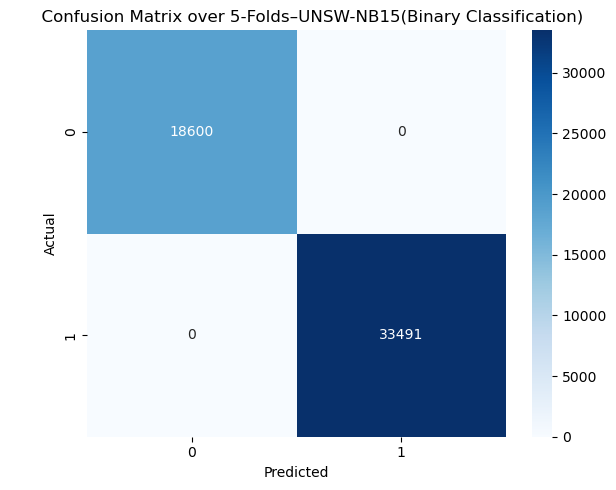

In [106]:

# --- Average Confusion Matrix (rounded to integers) ---
cm_avg = np.mean(all_cm, axis=0)
cm_avg_int = np.round(cm_avg).astype(int)  # Round to nearest integer

plt.figure(figsize=(6,5))
sns.heatmap(cm_avg_int, annot=True, fmt='d', cmap='Blues')
plt.title('      Confusion Matrix over 5-Folds–UNSW-NB15(Binary Classification)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("peerj_revision1_confusion_matrix_UNSW_NB15_Binary_ensemble.png", dpi=1200)
plt.show()



In [38]:
# --- Classification Report ---
print("\nAverage Classification Report:(Dynamic Ensemble Model)")
print(classification_report(y_true, y_pred_ensemble))


Average Classification Report:(Dynamic Ensemble Model)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     93000
         1.0       1.00      1.00      1.00    167457

    accuracy                           1.00    260457
   macro avg       1.00      1.00      1.00    260457
weighted avg       1.00      1.00      1.00    260457



In [63]:
# --- Classification Report for FNN ---
print("\nAverage Classification Report:(FNN)")
print(classification_report(y_true, y_pred_fnn))


Average Classification Report:(FNN)
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     93000
         1.0       0.96      1.00      0.98    167457

    accuracy                           0.98    260457
   macro avg       0.98      0.97      0.97    260457
weighted avg       0.98      0.98      0.98    260457



In [52]:
# --- Classification Report ---
print("\nAverage Classification Report:(CNN)")
print(classification_report(y_true, y_pred_cnn))


Average Classification Report:(CNN)
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94     93000
         1.0       0.94      1.00      0.97    167457

    accuracy                           0.96    260457
   macro avg       0.97      0.94      0.95    260457
weighted avg       0.96      0.96      0.96    260457



In [59]:
# --- Classification Report ---
print("\nAverage Classification Report:")
print(classification_report(y_true, y_pred_lstm))


Average Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     93000
         1.0       0.95      1.00      0.98    167457

    accuracy                           0.97    260457
   macro avg       0.98      0.95      0.96    260457
weighted avg       0.97      0.97      0.97    260457



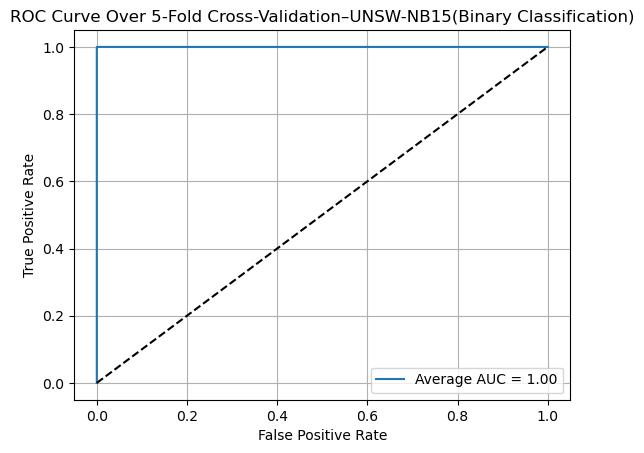

In [98]:
# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, y_prob_ensemble)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Average AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Over 5-Fold Cross-Validation–UNSW-NB15(Binary Classification)')

plt.legend()
plt.grid()
plt.savefig("peerj_revision1_ROCCurve_UNSW_NB15_Binary_ensemble.png",dpi=1200)
plt.show()

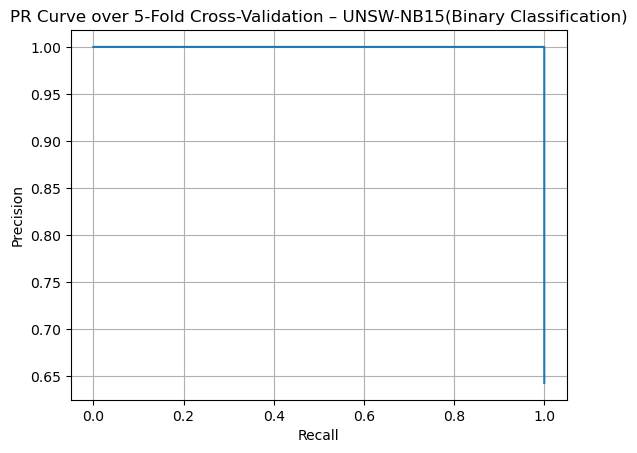

In [97]:
# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, y_prob_ensemble)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve over 5-Fold Cross-Validation – UNSW-NB15(Binary Classification)')
plt.grid()
plt.savefig("peerj_revision1_PRCurve_UNSW_NB15_Binary_ensemble.png",dpi=1200)
plt.show()

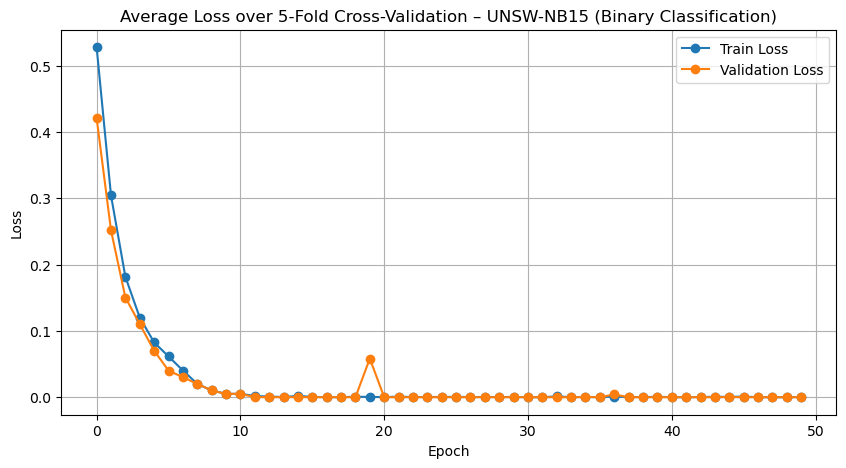

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(ensemble_history.history['loss'], label='Train Loss', marker='o')
plt.plot(ensemble_history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Average Loss over 5-Fold Cross-Validation – UNSW-NB15 (Binary Classification)')
plt.grid(True)
plt.savefig("peerj_revision1_UNSW_loss_binary.png",dpi=1200)
plt.show()

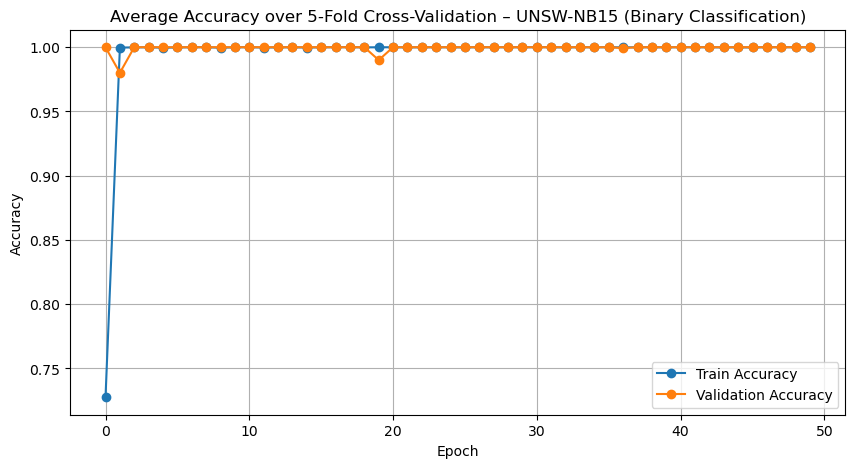

In [84]:
# Evaluate the model and visualize results
# Accuracy and loss plots
plt.figure(figsize=(10, 5))
plt.plot(ensemble_history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(ensemble_history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Average Accuracy over 5-Fold Cross-Validation – UNSW-NB15 (Binary Classification)')
plt.grid(True)
plt.savefig("Peerj_revision1_UNSWNB15_Accuracy_binary.png",dpi=1200)
plt.show()

In [85]:
# Extract and plot attention weights
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

# Check the shape of the attention weights to ensure it matches the number of features
print(f"Shape of attention_weights_test: {attention_weights_test.shape}")


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step
Shape of attention_weights_test: (52091, 22)


In [86]:
from tensorflow.keras.models import Model
import pandas as pd

# Extract the attention model
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)

# Predict attention weights for the full test set
attention_vals = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

avg_attention = np.mean(attention_vals, axis=0)

# Create DataFrame for plotting
attention_df = pd.DataFrame({
    'Feature': [f'Feature {i+1}' for i in range(len(avg_attention))],
    'Attention Weight': avg_attention
})


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step


In [89]:
# Assuming df_selected.columns contains the real feature names
feature_names = ['dur','proto','service','state','sbytes','dbytes','dload','sloss','sinpkt','sjit','swin','stcpb','dtcpb',
'dwin','synack','ackdat','dmean','trans_depth','ct_state_ttl','ct_dst_src_ltm','ct_ftp_cmd','ct_src_ltm']

# Create a DataFrame for visualization with actual feature names
attention_df = pd.DataFrame({
    'Feature': feature_names,
    'Attention Weight': avg_attention
})

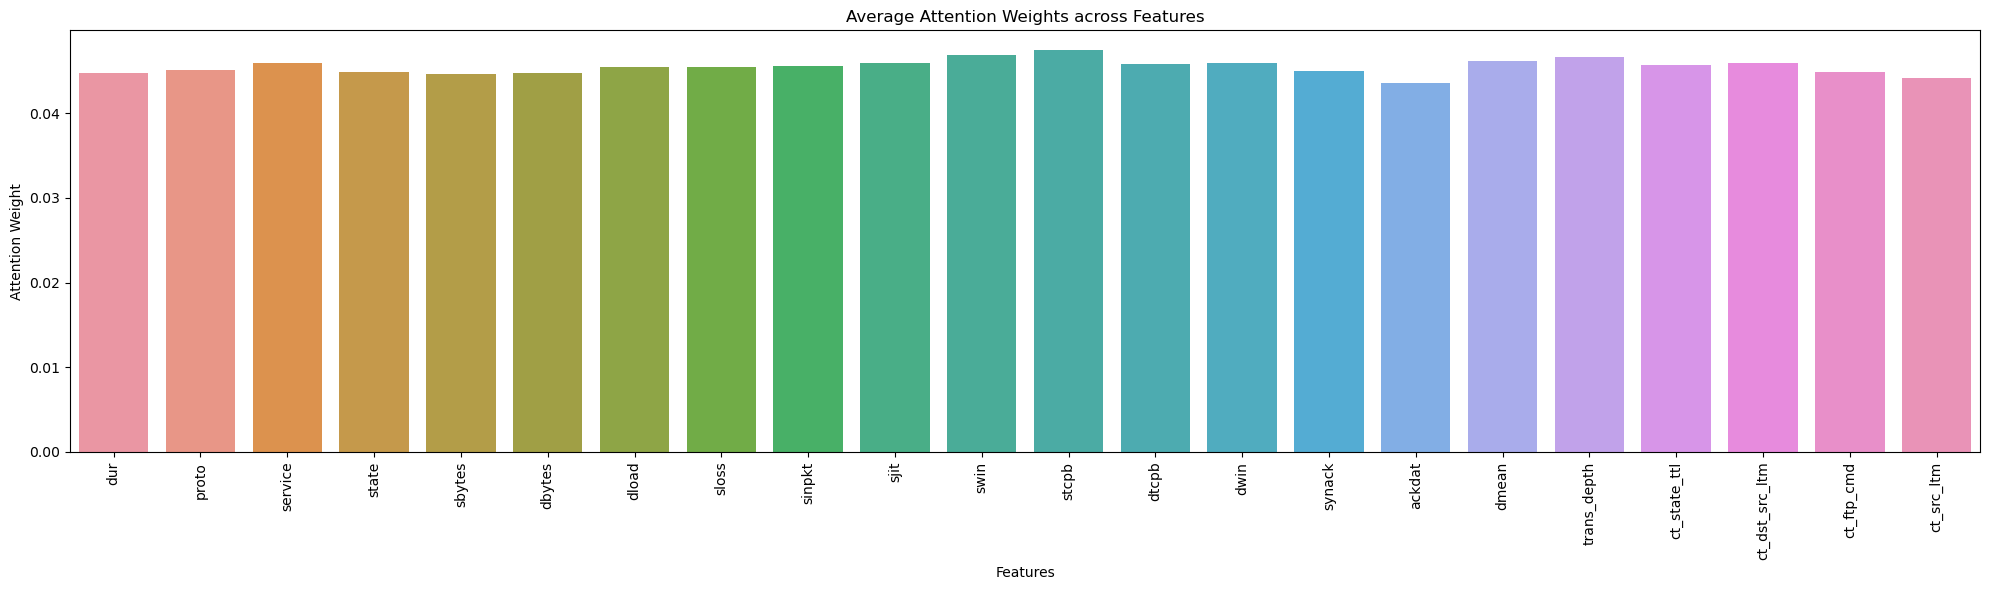

In [94]:
# Plot
plt.figure(figsize=(20, 6))
sns.barplot(x='Feature', y='Attention Weight', data=attention_df)
plt.title('Average Attention Weights across Features')
plt.xlabel('Features')
plt.ylabel('Attention Weight')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("peerj_revision1_UNSW_NB15_Binary_attention_ensemble.png",dpi=1200)
plt.show()

In [129]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_features_test and y_test_binary are already defined

# Apply t-SNE with tuned parameters
tsne = TSNE(
    n_components=2,
    perplexity=30,          # Try 50–80 for better global structure
    n_iter=3000,            # More iterations for convergence
    random_state=42,
    
)

tsne_results = tsne.fit_transform(combined_features_test)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Label': y_test_binary
})




C:\Users\ramya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


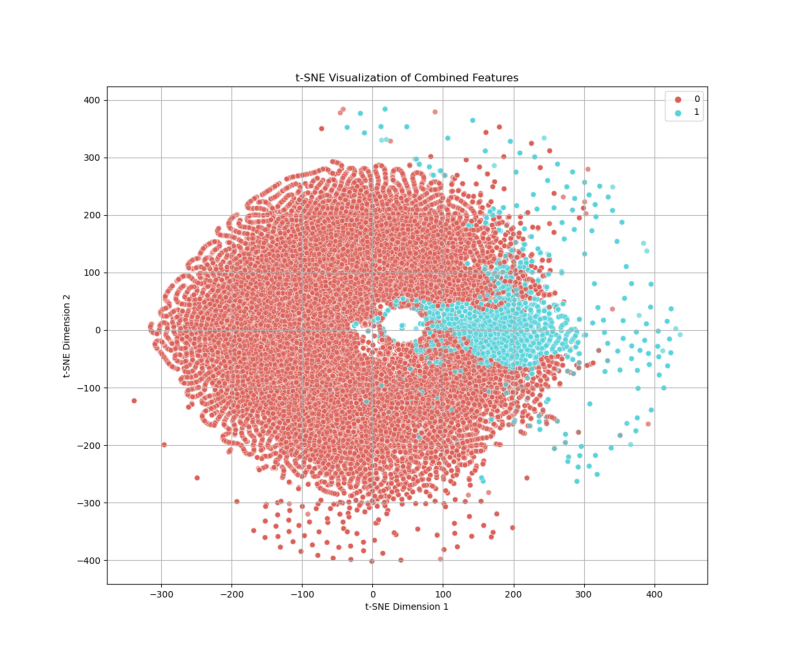

In [136]:
# Plot t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Label',
    palette=sns.color_palette('hls', 2),
   data=tsne_df,
    legend='full',
    alpha=0.6,
    s=30  # point size
)
plt.title('t-SNE Visualization of Combined Features)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.savefig("Peerj_revision1_UNSWNB15_Binary_tSNE.png", dpi=1200)
plt.show()
